<a href="https://colab.research.google.com/github/idrisdemir/KolektifProje/blob/main/ProjeOdevi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.8 MB/s eta 0:00:00


In [ ]:
#libraries
import torch
from torch import nn
from torch.nn.parameter import Parameter
import numpy as np
from torch.utils.data import DataLoader,StackDataset
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.feature_extraction.text import CountVectorizer
import time
import random
import matplotlib.pyplot as plt

#from mpl_toolkits.mplot3d import Axes3D


In [ ]:
batch_size = 64
epochs = 50
loss_fn = nn.CrossEntropyLoss()
num_ara_agirlik = 10


In [ ]:
# # Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

# ***Veri Seti***

In [ ]:
dataset = load_dataset("ag_news",split='train')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

# ***Prepare Veri Seti***

In [ ]:
#metin kümesinin vektör temsilleri elde ediliyor
vectorizer = CountVectorizer(max_features=1000,dtype='float32')
vectorizer.fit(dataset['text'])
text_vectors = vectorizer.transform(dataset['text']).toarray()

In [ ]:
#Veri setinin %15 'i test için ayrıldı

train_x, train_y = text_vectors[:45000],dataset['label'][:45000] #120000'in yüzde 15 i 102000'dir.
test_x, test_y = text_vectors[45000:50000],dataset['label'][45000:50000]

In [ ]:
train_dataset = StackDataset(text=train_x,label=train_y)
test_dataset = StackDataset(text=test_x,label=test_y)

In [ ]:
train_dataset = DataLoader(train_dataset,batch_size=batch_size)
test_dataset = DataLoader(test_dataset,batch_size=1)

In [ ]:
# Define model
class TextNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()
        self.linear_1 = nn.Linear(1000,256) #her bir vectör kısmında farklı değerler oluyor
        # self.linear_2 = nn.Linear(256,256)
        # self.linear_3 = nn.Linear(256,256)
        self.linear_4 = nn.Linear(256,4)

    def forward(self, x):
        x = self.linear_1(x)
        x = self.relu(x)
        # x = self.linear_2(x)
        # x = self.relu(x)
        # x = self.linear_3(x)
        # x = self.relu(x)
        logits = self.linear_4(x)
        return logits
    def get_parameters(self):
      linear1_w = np.reshape(self.linear_1.weight.cpu().detach().numpy(),(-1,))
      linear1_b = np.reshape(self.linear_1.bias.cpu().detach().numpy(),(-1,))
      linear2_w = np.reshape(self.linear_2.weight.cpu().detach().numpy(),(-1,))
      linear2_b = np.reshape(self.linear_2.bias.cpu().detach().numpy(),(-1,))
      linear3_w = np.reshape(self.linear_3.weight.cpu().detach().numpy(),(-1,))
      linear3_b = np.reshape(self.linear_3.bias.cpu().detach().numpy(),(-1,))
      linear4_w = np.reshape(self.linear_4.weight.cpu().detach().numpy(),(-1,))
      linear4_b = np.reshape(self.linear_4.bias.cpu().detach().numpy(),(-1,))
      weights = np.concatenate((linear1_w,linear1_b,linear2_w,linear2_b,linear3_w,linear3_b,linear4_w,linear4_b))
      return weights
    def load_parameters(self,parameters):
      print(len(parameters))
      self.linear_1.weigth = Parameter(torch.tensor(parameters[:1000*256]))
      self.linear_1.bias = Parameter(torch.tensor(parameters[1000*256:1000*256 + 256]))
      self.linear_2.weight = Parameter(torch.tensor(parameters[1000*256 + 256:1000*256 + 256 + 256*256]).reshape(256,256))
      self.linear_2.bias = Parameter(torch.tensor(parameters[1000*256 + 256 + 256*256:1000*256 + 256 + 256*256 +256]))
      self.linear_3.weight = Parameter(torch.tensor(parameters[1000*256 + 256 + 256*256 +256:1000*256 + 256 + 256*256 +256+256*256]).reshape(256,256))
      self.linear_3.bias = Parameter(torch.tensor(parameters[1000*256 + 256 + 256*256 +256+256*256:1000*256 + 256 + 256*256 +256+256*256+256]))
      self.linear_4.weight = Parameter(torch.tensor(parameters[1000*256 + 256 + 256*256 +256+256*256+256:1000*256 + 256 + 256*256 +256+256*256+256+256*4]).reshape(4,256))
      self.linear_4.bias = Parameter(torch.tensor(parameters[1000*256 + 256 + 256*256 +256+256*256+256+256*4:1000*256 + 256 + 256*256 +256+256*256+256+256*4 + 4]))

# ***Training***

In [ ]:
#veri kümesi ve model veriliyor. O model o veri kümesi ile eğitiliyor. Eğitilen model döndürülüyor.
def train(ds,model,cycle):
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
  for epoch in range(cycle):
    start_time = time.perf_counter()
    print(f"Epoch {epoch+1}\n-------------------------------")
    size = len(ds.dataset)
    model.train()
    for batch_no, batch in enumerate(ds):
      X, y = batch['text'].to(device), batch['label'].to(device)

      # Compute prediction error
      pred = model(X)
      loss = loss_fn(pred, y)

      # Backpropagation
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      if batch_no % 100 == 0:
          loss, current = loss.item(), (batch_no + 1) * len(X)
          print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
  return model

In [ ]:
model1 = TextNetwork().to(device)
model1 = train(train_dataset,model1,epochs)

Epoch 1
-------------------------------
loss: 1.401516  [   64/45000]
loss: 1.272668  [ 6464/45000]
loss: 1.140389  [12864/45000]
loss: 0.928292  [19264/45000]
loss: 0.707044  [25664/45000]
loss: 0.493014  [32064/45000]
loss: 0.482289  [38464/45000]
loss: 0.454620  [44864/45000]
Epoch 2
-------------------------------
loss: 1.106696  [   64/45000]
loss: 0.508432  [ 6464/45000]
loss: 0.489996  [12864/45000]
loss: 0.489504  [19264/45000]
loss: 0.548817  [25664/45000]
loss: 0.308610  [32064/45000]
loss: 0.297038  [38464/45000]
loss: 0.345189  [44864/45000]
Epoch 3
-------------------------------
loss: 1.058449  [   64/45000]
loss: 0.443147  [ 6464/45000]
loss: 0.434838  [12864/45000]
loss: 0.431840  [19264/45000]
loss: 0.542829  [25664/45000]
loss: 0.284105  [32064/45000]
loss: 0.239817  [38464/45000]
loss: 0.315224  [44864/45000]
Epoch 4
-------------------------------
loss: 1.026763  [   64/45000]
loss: 0.410873  [ 6464/45000]
loss: 0.415434  [12864/45000]
loss: 0.401213  [19264/45000]


In [ ]:
model2 = TextNetwork().to(device)
model2 = train(train_dataset,model2,epochs)

Epoch 1
-------------------------------
loss: 1.383341  [   64/45000]
loss: 1.282107  [ 6464/45000]
loss: 1.149798  [12864/45000]
loss: 0.922822  [19264/45000]
loss: 0.718582  [25664/45000]
loss: 0.498752  [32064/45000]
loss: 0.473095  [38464/45000]
loss: 0.449015  [44864/45000]
Epoch 2
-------------------------------
loss: 1.102859  [   64/45000]
loss: 0.504587  [ 6464/45000]
loss: 0.496488  [12864/45000]
loss: 0.487356  [19264/45000]
loss: 0.554065  [25664/45000]
loss: 0.310132  [32064/45000]
loss: 0.294309  [38464/45000]
loss: 0.339301  [44864/45000]
Epoch 3
-------------------------------
loss: 1.057982  [   64/45000]
loss: 0.442226  [ 6464/45000]
loss: 0.440210  [12864/45000]
loss: 0.432532  [19264/45000]
loss: 0.545864  [25664/45000]
loss: 0.285104  [32064/45000]
loss: 0.238976  [38464/45000]
loss: 0.310605  [44864/45000]
Epoch 4
-------------------------------
loss: 1.027382  [   64/45000]
loss: 0.410505  [ 6464/45000]
loss: 0.419817  [12864/45000]
loss: 0.403099  [19264/45000]


In [ ]:
model3 = TextNetwork().to(device)
model3 = train(train_dataset,model3,epochs)

Epoch 1
-------------------------------
loss: 1.431447  [   64/45000]
loss: 1.300433  [ 6464/45000]
loss: 1.162027  [12864/45000]
loss: 0.939730  [19264/45000]
loss: 0.725000  [25664/45000]
loss: 0.515132  [32064/45000]
loss: 0.480635  [38464/45000]
loss: 0.460396  [44864/45000]
Epoch 2
-------------------------------
loss: 1.104211  [   64/45000]
loss: 0.507691  [ 6464/45000]
loss: 0.496269  [12864/45000]
loss: 0.488515  [19264/45000]
loss: 0.548973  [25664/45000]
loss: 0.314051  [32064/45000]
loss: 0.296790  [38464/45000]
loss: 0.346202  [44864/45000]
Epoch 3
-------------------------------
loss: 1.057168  [   64/45000]
loss: 0.442292  [ 6464/45000]
loss: 0.437828  [12864/45000]
loss: 0.432895  [19264/45000]
loss: 0.541722  [25664/45000]
loss: 0.287653  [32064/45000]
loss: 0.240515  [38464/45000]
loss: 0.314291  [44864/45000]
Epoch 4
-------------------------------
loss: 1.026380  [   64/45000]
loss: 0.410144  [ 6464/45000]
loss: 0.416162  [12864/45000]
loss: 0.403029  [19264/45000]


In [ ]:
model4 = TextNetwork().to(device)
model4 = train(train_dataset,model4,epochs)

Epoch 1
-------------------------------
loss: 1.453301  [   64/45000]
loss: 1.280664  [ 6464/45000]
loss: 1.145816  [12864/45000]
loss: 0.921813  [19264/45000]
loss: 0.697360  [25664/45000]
loss: 0.501936  [32064/45000]
loss: 0.473097  [38464/45000]
loss: 0.457632  [44864/45000]
Epoch 2
-------------------------------
loss: 1.110448  [   64/45000]
loss: 0.508193  [ 6464/45000]
loss: 0.498631  [12864/45000]
loss: 0.487372  [19264/45000]
loss: 0.541188  [25664/45000]
loss: 0.309521  [32064/45000]
loss: 0.294744  [38464/45000]
loss: 0.349000  [44864/45000]
Epoch 3
-------------------------------
loss: 1.055741  [   64/45000]
loss: 0.442725  [ 6464/45000]
loss: 0.440816  [12864/45000]
loss: 0.432873  [19264/45000]
loss: 0.536925  [25664/45000]
loss: 0.282899  [32064/45000]
loss: 0.239894  [38464/45000]
loss: 0.318142  [44864/45000]
Epoch 4
-------------------------------
loss: 1.021229  [   64/45000]
loss: 0.409581  [ 6464/45000]
loss: 0.419261  [12864/45000]
loss: 0.403127  [19264/45000]


In [ ]:
model5 = TextNetwork().to(device)
model5 = train(train_dataset,model5,epochs)

Epoch 1
-------------------------------
loss: 1.381808  [   64/45000]
loss: 1.292628  [ 6464/45000]
loss: 1.166181  [12864/45000]
loss: 0.945302  [19264/45000]
loss: 0.705773  [25664/45000]
loss: 0.516844  [32064/45000]
loss: 0.481619  [38464/45000]
loss: 0.453475  [44864/45000]
Epoch 2
-------------------------------
loss: 1.108063  [   64/45000]
loss: 0.514024  [ 6464/45000]
loss: 0.498908  [12864/45000]
loss: 0.486874  [19264/45000]
loss: 0.541477  [25664/45000]
loss: 0.311674  [32064/45000]
loss: 0.294136  [38464/45000]
loss: 0.342542  [44864/45000]
Epoch 3
-------------------------------
loss: 1.067343  [   64/45000]
loss: 0.449522  [ 6464/45000]
loss: 0.440527  [12864/45000]
loss: 0.428208  [19264/45000]
loss: 0.537405  [25664/45000]
loss: 0.283920  [32064/45000]
loss: 0.238513  [38464/45000]
loss: 0.312301  [44864/45000]
Epoch 4
-------------------------------
loss: 1.034236  [   64/45000]
loss: 0.416405  [ 6464/45000]
loss: 0.419758  [12864/45000]
loss: 0.397773  [19264/45000]


In [ ]:
modeller = [model1,model2,model3,model4,model5]

In [ ]:
for i in range(5):
  PATH = "drive/MyDrive/Kollektif3modeller/n" + str(i+1)
  torch.save(modeller[i],PATH)

# ***Test***

In [ ]:
def test_score(ds,model):
  size = 0
  model = model.to(device)
  model.eval()
  test_loss, accuracy = 0,0
  preds = []
  with torch.no_grad():
    for sample in ds:
      X = sample['text']
      y = sample['label']
      X, y = X.to(device), y.to(device)
      pred = model(X)
      preds.append((pred.argmax(1) == y).type(torch.float))
      test_loss += loss_fn(pred, y).item()
      accuracy += (pred.argmax(1) == y).type(torch.float).sum().item() #batch_accuracy
      size += len(X)
  accuracy = accuracy / size
  test_loss = test_loss / len(ds)
  return accuracy, test_loss, preds

In [ ]:
def ara_agirliklar_olustur2(num_point,model1,model2):
  a1 = model1.state_dict()
  a2 = model2.state_dict()
  ara_agirliklar = []
  for i in range(num_point):
    alpha = random.random()
    ara_agirlik = {}
    for key, values in a1.items():
      a1[key] = [value * alpha for value in values]
    for key, values in a2.items():
      a2[key] = [value * (1-alpha) for value in values]
    for a1_item, a2_item in zip(a1.items(),a2.items()):
      a1_key, a1_values = a1_item
      _ , a2_values = a2_item
      ara_agirlik[a1_key] = torch.tensor([np.array(x1.cpu())+np.array(x2.cpu()) for x1,x2 in zip(a1_values,a2_values)])
    ara_agirliklar.append(ara_agirlik)
  return ara_agirliklar

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
for i in range(1,6):
  PATH = "drive/MyDrive/Kollektif3modeller/n" + str(i)
  model1 = torch.load(PATH)
  for j in range(i+1,6):
    PATH = "drive/MyDrive/Kollektif3modeller/n" + str(j)
    model2 = torch.load(PATH)
    ara_agirliklar = ara_agirliklar_olustur2(num_ara_agirlik,model1,model2)
    for k in range(num_ara_agirlik):
      ara_model = TextNetwork().to(device)
      ara_model.load_state_dict(ara_agirliklar[k])
      PATH = "drive/MyDrive/" + str(i) + "_" + str(j) + "_ara_modeller/eski/n" + str(k)
      torch.save(ara_model,PATH)
      train(train_dataset,ara_model,5)
      PATH = "drive/MyDrive/" + str(i) + "_" + str(j) + "_ara_modeller/yeni/n" + str(k)
      torch.save(ara_model,PATH)


<ipython-input-13-c02c13951b5c>:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  ara_agirlik[a1_key] = torch.tensor([np.array(x1.cpu())+np.array(x2.cpu()) for x1,x2 in zip(a1_values,a2_values)])


Epoch 1
-------------------------------
loss: 0.682726  [   64/45000]
loss: 0.176900  [ 6464/45000]
loss: 0.203950  [12864/45000]
loss: 0.214830  [19264/45000]
loss: 0.268252  [25664/45000]
loss: 0.137455  [32064/45000]
loss: 0.088452  [38464/45000]
loss: 0.191791  [44864/45000]
Epoch 2
-------------------------------
loss: 0.566775  [   64/45000]
loss: 0.175586  [ 6464/45000]
loss: 0.188954  [12864/45000]
loss: 0.212481  [19264/45000]
loss: 0.251527  [25664/45000]
loss: 0.129448  [32064/45000]
loss: 0.080289  [38464/45000]
loss: 0.181330  [44864/45000]
Epoch 3
-------------------------------
loss: 0.552994  [   64/45000]
loss: 0.169808  [ 6464/45000]
loss: 0.176955  [12864/45000]
loss: 0.206902  [19264/45000]
loss: 0.240315  [25664/45000]
loss: 0.124538  [32064/45000]
loss: 0.074945  [38464/45000]
loss: 0.173961  [44864/45000]
Epoch 4
-------------------------------
loss: 0.537229  [   64/45000]
loss: 0.164514  [ 6464/45000]
loss: 0.166954  [12864/45000]
loss: 0.200873  [19264/45000]


In [ ]:
num_1 = "4"
num_2 = "5"
name = num_1 + "_" + num_2

In [ ]:
#burada test grafikleri çizdirilecek

PATH = "drive/MyDrive/Kollektif3modeller/n" + num_1
model1 = torch.load(PATH,map_location=torch.device('cpu'))

704

In [ ]:
PATH = "drive/MyDrive/Kollektif3modeller/n" + num_2
model2 = torch.load(PATH,map_location=torch.device('cpu'))

In [ ]:
eski_ara_modeller = []
yeni_ara_modeller = []
for k in range(num_ara_agirlik):
  PATH = "drive/MyDrive/" + name + "_ara_modeller/eski/n" + str(k)
  ara_model = torch.load(PATH,map_location=torch.device('cpu'))
  #ara_model.load_state_dict(ara_agirliklar[i])
  eski_ara_modeller.append(ara_model)
  PATH = "drive/MyDrive/" + name + "_ara_modeller/yeni/n" + str(k)
  ara_model = torch.load(PATH,map_location=torch.device('cpu'))
  yeni_ara_modeller.append(ara_model)

In [ ]:
eski_test_scores = []
eski_model_scores = []
_,score,_ = test_score(test_dataset,model1)
eski_test_scores.append(score)
for ara_model in eski_ara_modeller:
  _,score,_ = test_score(test_dataset,ara_model)
  eski_model_scores.append(score)
  eski_test_scores.append(score)
_,score,_ = test_score(test_dataset,model2)
eski_test_scores.append(score)

In [ ]:
yeni_test_scores = []
yeni_model_scores = []
accuracies = []
predictions = []
acc,score,preds = test_score(test_dataset,model1)
predictions.append(preds)
accuracies.append(acc)
yeni_test_scores.append(score)
for ara_model in yeni_ara_modeller:
  acc,score,preds = test_score(test_dataset,ara_model)
  accuracies.append(acc)
  predictions.append(preds)
  yeni_model_scores.append(score)
  yeni_test_scores.append(score)
acc,score,preds = test_score(test_dataset,model2)
accuracies.append(acc)
predictions.append(preds)
yeni_test_scores.append(score)

Text(0, 0.5, 'loss')

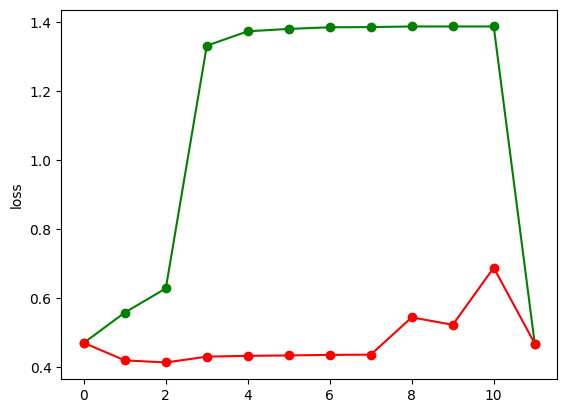

In [ ]:
import matplotlib.pyplot as plt
plt.plot(eski_test_scores,"go-")
plt.plot(yeni_test_scores,"ro-")
plt.ylabel("loss")

In [ ]:
print(accuracies)

[0.8464, 0.8508, 0.8518, 0.8486, 0.8478, 0.8478, 0.8472, 0.847, 0.843, 0.8434, 0.8082, 0.8464]


In [ ]:
from collections import Counter
def ensembling_preds(predictions:list):
  n_preds = len(predictions)
  n_pred = len(predictions[0])
  ensemble = []
  ensemble_acc = 0
  for j in range(n_pred):
    for i in range(n_preds):
      ensemble.append(predictions[i][j])
    eleman_sayilari = Counter(ensemble)
    en_cok_gecen_eleman, _ = eleman_sayilari.most_common(1)[0]
    if(en_cok_gecen_eleman==1):
      ensemble_acc += 1
    ensemble = []
  ensemble_acc /= n_pred
  return ensemble_acc

In [ ]:
#ana_preds = [predictions[0],predictions[-1]]
ara_preds = predictions[1:-1]
#ana_acc = ensembling_preds(ana_preds)
ara_acc = ensembling_preds(ara_preds)

print("ara_acc: " + str(ara_acc))
#print("ana_acc: " + str(ana_acc))

ara_acc: 0.8508


In [ ]:
predictions = []
for num_1 in range(5):
  PATH = "drive/MyDrive/Kollektif3modeller/n" + str(num_1+1)
  model = torch.load(PATH)
  _,_,preds = test_score(test_dataset,model)
  predictions.append(preds)
acc = ensembling_preds(predictions)
acc


0.845